In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
import operator
from sklearn.metrics import roc_curve, auc

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df=pd.read_csv('Clothing_Store.csv')

In [3]:
df=df.head(7000)

In [4]:
del df['CLUSTYPE']
del df['HHKEY'], df['ZIP_CODE'], df['REC'], df['PC_CALC20'] 
del df['STORELOY']

In [5]:
# df.info()

In [6]:
df['VALPHON']=(df['VALPHON']=='Y')*1

In [7]:
for v in df.columns:
    l=df[v].unique()
    if len(l)<5:
        print v,l

CC_CARD [0 1]
VALPHON [0 1]
WEB [0 1]
RESP [0 1]


In [8]:
df.shape

(7000, 45)

In [9]:
numerical_variable_list=[]
for v in df.columns:
    l=df[v].unique()
    if len(l)>5:
        numerical_variable_list.append(v)
len(numerical_variable_list)

41

In [10]:
categorical_variable_list=[]
for v in df.columns:
    if v!='RESP':
        l=df[v].unique()
        if len(l)<5:
            categorical_variable_list.append(v)
len(categorical_variable_list)

3

#### Look at data

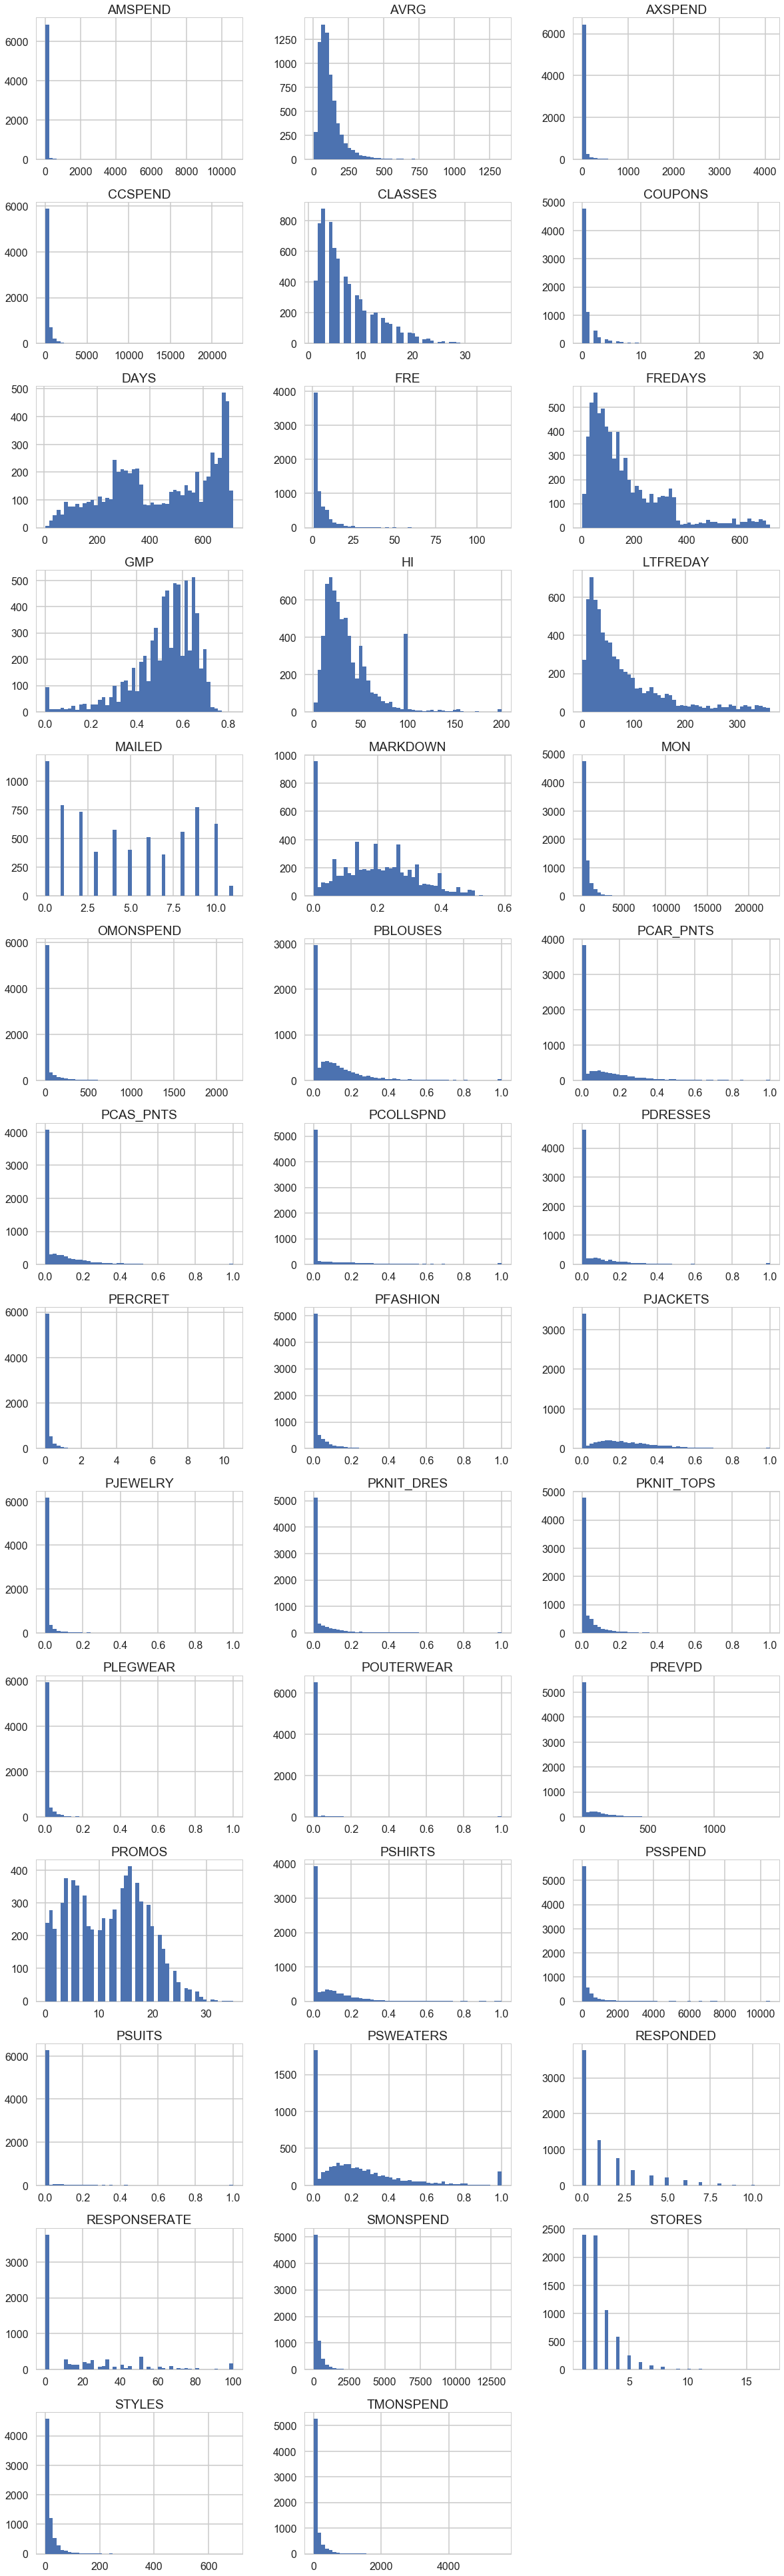

In [11]:
import matplotlib.pyplot as plt
df[numerical_variable_list].hist(bins=50, figsize=(20,70),layout=(14,3))
plt.savefig("numeric_histogram_plots")
plt.show()

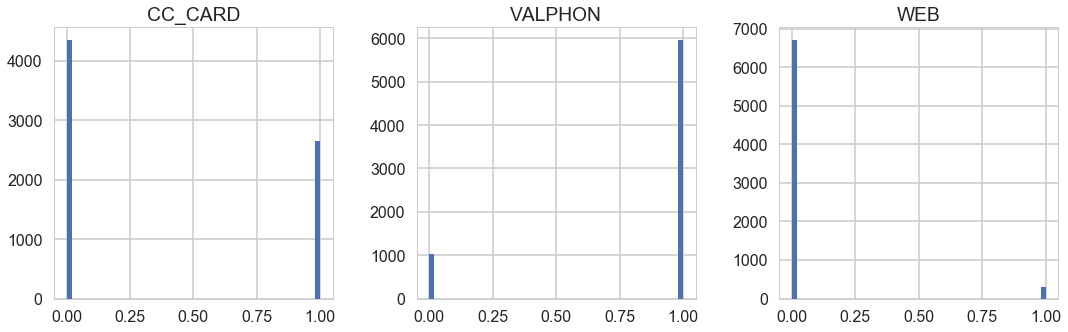

In [12]:
df[categorical_variable_list].hist(bins=50, figsize=(18,5),layout=(1,3))
plt.savefig("categorical_histogram_plots")
plt.show()

#### One finding and one problem
* One problem: Distribution of many variables are right skewed
* One finding: indicator variables might be added to address the importance of absence. columns where the existence or lack thereof of a zero may be important in a classifier. We used our intuition to make these choices, believing that there is additional information encoded in say, PERCRET: if you never returned anything you might not be a budget shopper and thus someone who might have the money to shop quite a bit...
* Adding new variable might be helpful for classification


In [13]:
ZERO_IMPORTANT_VARS = [u'PREVPD', u'AMSPEND', u'PSSPEND', u'CCSPEND', u'AXSPEND', u'RESPONDED', u'PERCRET']

In [14]:
PERCENT_VARS=[ u'PSWEATERS', u'PKNIT_TOPS', u'PKNIT_DRES', u'PBLOUSES', u'PJACKETS', u'PCAR_PNTS', u'PCAS_PNTS', u'PSHIRTS', 
              u'PDRESSES', u'PSUITS', u'POUTERWEAR', u'PJEWELRY', u'PFASHION', u'PLEGWEAR', u'PCOLLSPND']
len(PERCENT_VARS)

15

In [15]:
for p in ZERO_IMPORTANT_VARS:
    df['i_'+p]=(df[p] > 0.0)*1
    categorical_variable_list.append('i_'+p)

In [16]:
for p in PERCENT_VARS:
    df['i_'+p]=(df[p] > 0.0)*1
    categorical_variable_list.append('i_'+p)

In [17]:
#create recent usage (1 month and 3 month),  sale-shopper (markdown+coupon)
df["i_RECENT"]=1*((df.OMONSPEND > 0) | (df.TMONSPEND > 0))
df["i_SAVER"]=1*((df.MARKDOWN > 0) | (df.COUPONS > 0))
categorical_variable_list.append("i_RECENT")
categorical_variable_list.append("i_SAVER")

In [18]:
len(categorical_variable_list),len(numerical_variable_list)

(27, 41)

#### Log transformation and square root transformation for numerical variables to reduce variance. Whole dateset.
* value include zero uses square root
* value not include zeor uses log

In [19]:
numeric_vars_inld_zero=[]
numeric_vars_not_inld_zero=[]
for i,j in dict(df[numerical_variable_list].describe().min()).items():
    if j==0:
        numeric_vars_inld_zero.append(i)
    if j>0:
        numeric_vars_not_inld_zero.append(i)

In [20]:
df_fe=pd.concat([np.log(df[numeric_vars_not_inld_zero]), np.sqrt(df[numeric_vars_inld_zero]),df[categorical_variable_list],
              df['RESP']], axis=1)
df_fe.head()

,STORES,DAYS,HI,LTFREDAY,STYLES,AVRG,FRE,CCSPEND,CLASSES,MON,FREDAYS,PDRESSES,PKNIT_TOPS,PCAS_PNTS,AXSPEND,MAILED,PJEWELRY,RESPONSERATE,PSHIRTS,SMONSPEND,PSWEATERS,RESPONDED,OMONSPEND,AMSPEND,PBLOUSES,PFASHION,COUPONS,MARKDOWN,PREVPD,PCOLLSPND,PSSPEND,GMP,PJACKETS,PKNIT_DRES,PROMOS,PERCRET,POUTERWEAR,TMONSPEND,PCAR_PNTS,PSUITS,PLEGWEAR,CC_CARD,VALPHON,WEB,i_PREVPD,i_AMSPEND,i_PSSPEND,i_CCSPEND,i_AXSPEND,i_RESPONDED,i_PERCRET,i_PSWEATERS,i_PKNIT_TOPS,i_PKNIT_DRES,i_PBLOUSES,i_PJACKETS,i_PCAR_PNTS,i_PCAS_PNTS,i_PSHIRTS,i_PDRESSES,i_PSUITS,i_POUTERWEAR,i_PJEWELRY,i_PFASHION,i_PLEGWEAR,i_PCOLLSPND,i_RECENT,i_SAVER,RESP
0,0.0,6.501290,3.459781,4.709530,2.397895,5.216185,0.693147,5.909332,2.197225,5.909332,5.808142,0.000000,0.000000,0.000000,0.0,2.236068,0.000000,0.000000,0.435890,0.000000,0.424264,0.000000,0.000000,0.0,0.547723,0.141421,1.000000,0.282843,0.000000,0.538516,0.0,0.774597,0.000000,0.000000,4.123106,0.000000,0.0,0.000000,0.500000,0.0,0.173205,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,1,0,1,0
1,0.0,6.545350,3.487987,3.772761,2.639057,4.166665,1.386294,5.552960,1.791759,5.552960,5.159055,0.424264,0.400000,0.374166,0.0,2.000000,0.000000,7.071068,0.000000,16.062378,0.509902,1.414214,7.482647,0.0,0.000000,0.000000,0.000000,0.574456,0.000000,0.608276,0.0,0.734847,0.000000,0.000000,3.741657,0.173205,0.0,11.747340,0.424264,0.0,0.141421,1,1,0,0,0,0,1,0,1,1,1,1,0,0,0,1,1,0,1,0,0,0,0,1,1,1,1,1
2,0.0,5.837730,4.605170,4.228293,0.693147,3.650658,0.693147,4.343805,0.000000,4.343805,5.144583,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.331662,6.244998,0.000000,0.0,0.787401,0.000000,0.000000,3.162278,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.0,6.552508,3.147165,3.294354,3.555348,4.661078,2.079442,6.740590,2.708050,6.740590,4.473009,0.000000,0.000000,0.000000,0.0,3.000000,0.072849,8.165170,0.223607,19.335718,0.616441,2.449490,0.000000,0.0,0.244949,0.173205,1.732051,0.538516,12.893797,0.000000,0.0,0.655744,0.447214,0.223607,4.898979,0.000000,0.0,10.244023,0.412311,0.0,0.100000,1,1,0,1,0,0,1,0,1,0,1,0,1,1,1,1,0,1,0,0,0,1,1,1,0,1,1,0
4,0.0,3.891820,3.350606,3.198673,2.079442,4.470953,0.000000,4.470953,1.386294,4.470953,3.891820,0.000000,0.447214,0.640312,0.0,0.000000,0.412311,0.000000,0.000000,9.350936,0.447214,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.648074,0.000000,0.000000,0.0,0.469042,0.000000,0.000000,0.000000,0.000000,0.0,9.350936,0.000000,0.0,0.000000,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0


Check numerical variables again after transfromation

In [21]:
# df_fe[numerical_variable_list].hist(bins=50, figsize=(20,70),layout=(14,3))
# # plt.savefig("numeric_histogram_plots_after_transform")
# plt.show()

### Test and Training Sets, and Standardization

#### Train Test Split

In [22]:
X=df_fe[categorical_variable_list+numerical_variable_list]
y=df_fe['RESP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [23]:
X_train.shape,X_test.shape

((4900, 68), (2100, 68))

#### Standardization

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[numerical_variable_list] = scaler.fit_transform(X_train[numerical_variable_list])
X_test[numerical_variable_list]= scaler.fit_transform(X_test[numerical_variable_list])

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

In [25]:
df_train=X_train.copy()
df_train['RESP']=y_train

#### Reletionship between predictors and repsonse variable.

C:\Anaconda2\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


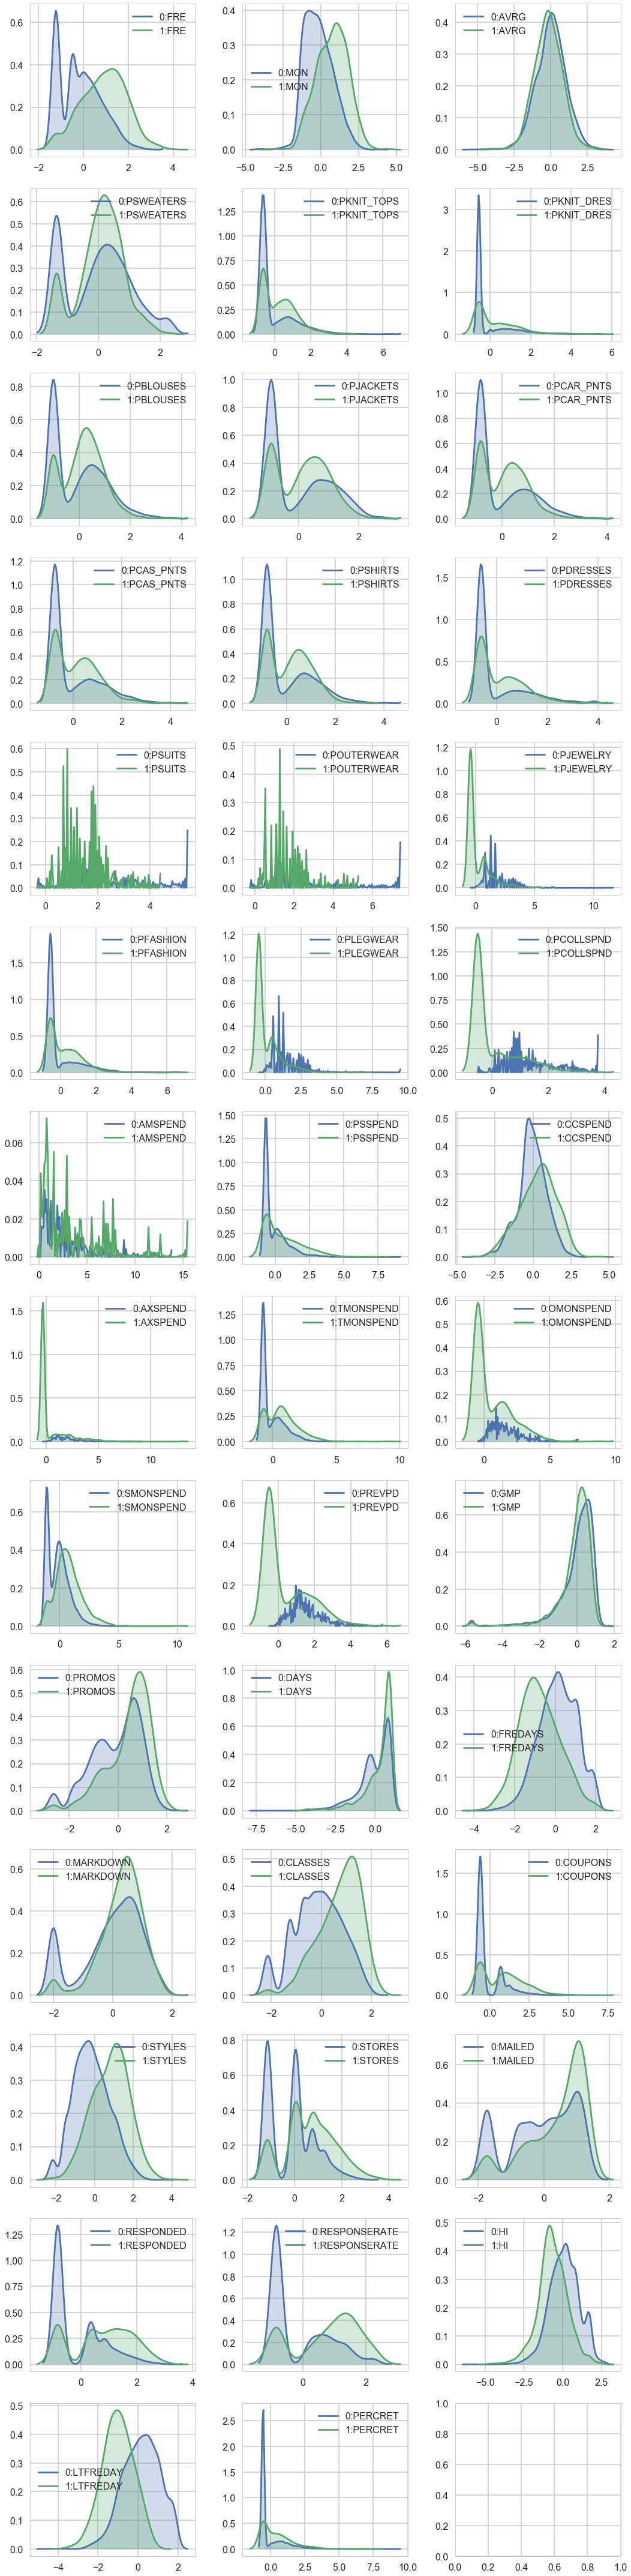

In [26]:
dfgb=df_train.groupby('RESP')
fig, axes = plt.subplots(nrows=14, ncols=3, figsize=(15, 60), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), numerical_variable_list):
    for k, v in dfgb[p]:
        sns.kdeplot(v, ax=ax, label=str(k)+":"+v.name,shade=True)
plt.savefig('Relationships Between the Numeric Predictors and the Response')
plt.show()

In [27]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), 
#                          tight_layout=True)

# for ax, p in zip(axes.ravel(), categorical_variable_list): 
#     table=pd.crosstab(df_train[p],df_train['RESP'])
#     table.div(table.sum(1).astype(float), axis=0).plot(kind='bar',ax=ax,stacked='True')
# plt.savefig('Relationships Between the Categorical Predictors and the Response')
# plt.show()

#### Feature selection

We can also get a notion of which features are important in the classification process by seeing how they correlate with the response. Implement some code to obtain the Pearson correlation coefficient between each of our features and the response. Do this on the training set only! Create a dataframe indexed by the features, which has columns abscorr the absolute value of the correlation and corr the value of the correlation. Sort the dataframe by abscorr, highest first, and show the top 25 features with the highest absolute correlation.

In [28]:
from scipy.stats.stats import pearsonr
correlations=[]
dftousetrain=df_train
for col in dftousetrain[numerical_variable_list+categorical_variable_list].columns.values:
    r=pearsonr(dftousetrain[col].values, df_train['RESP'].values)[0]
    correlations.append(dict(feature=col,corr=r, abscorr=np.abs(r)))

bpdf=pd.DataFrame(correlations).sort('abscorr', ascending=False)
bpdf.set_index(['feature'], inplace=True)
bpdf.head(30)

C:\Anaconda2\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Anaconda2\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  t_squared = r**2 * (df / ((1.0 - r) * (1.0 + r)))
C:\Anaconda2\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in absolute
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,abscorr,corr
feature,,
LTFREDAY,0.428306,-0.428306
FRE,0.388324,0.388324
STYLES,0.355294,0.355294
COUPONS,0.329967,0.329967
RESPONDED,0.329562,0.329562
SMONSPEND,0.327217,0.327217
FREDAYS,0.325465,-0.325465
RESPONSERATE,0.322698,0.322698
MON,0.322017,0.322017


In [29]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
estimator = SVR(kernel="linear")
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)
selector.support_ 

selector.ranking_


array([1, 1, 1, 1, 1, 6, 4, 3, 2, 5])

In [30]:
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

In [31]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals

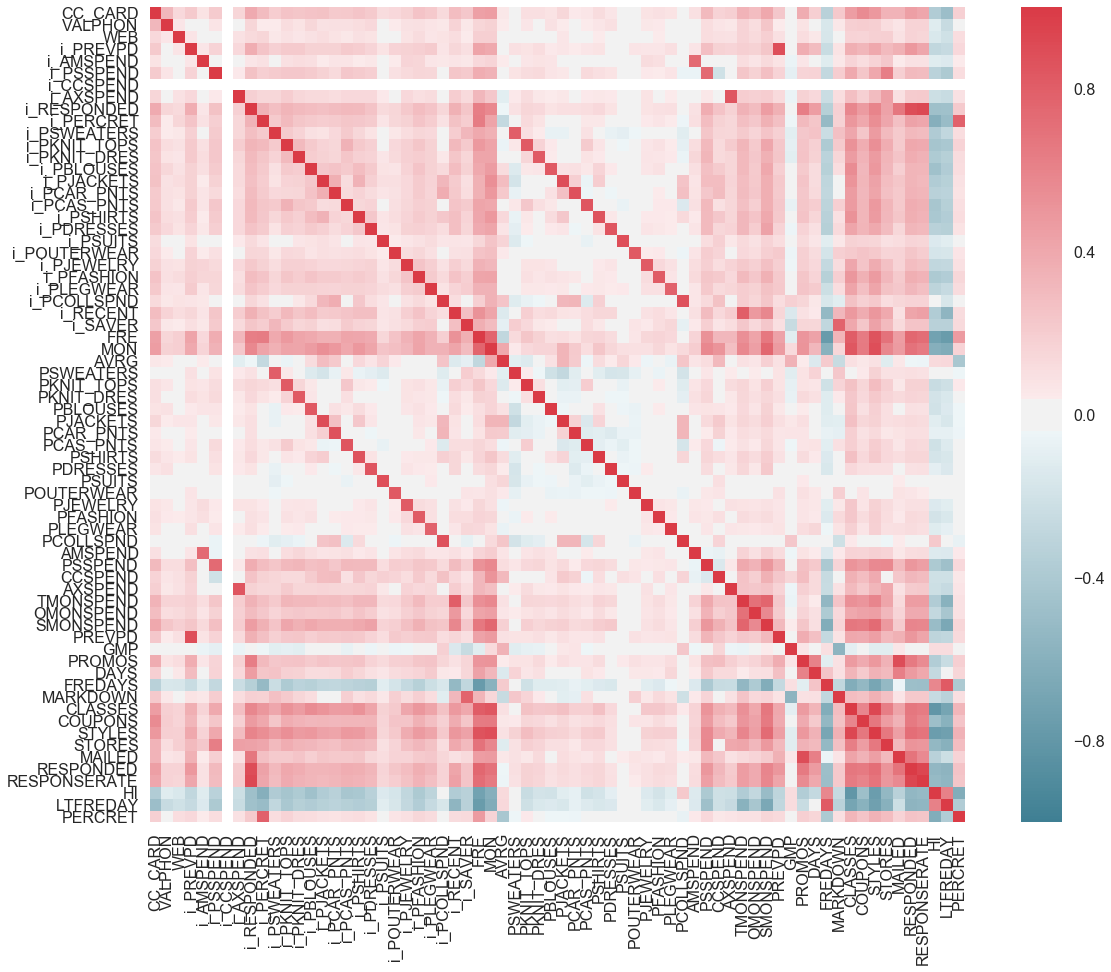

In [112]:
import seaborn as sns

f, ax = plt.subplots(figsize=(20, 15))
corr = X_train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

### M phase

In [32]:

def cv_optimize(clf, parameters, X_train, y_train, X_test, y_test, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters,  cv=n_folds)
    gs.fit(X_train, y_train)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    clf = gs.best_estimator_
    clf=clf.fit(X_train, y_train)
    training_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(y_test, clf.predict(X_test))
    print "########################################################"
    return clf

In [33]:
%%time
from sklearn.linear_model import LogisticRegression
logclf=LogisticRegression(penalty="l1")
c={"C": [0.001, 0.1,10.0,100.0]}
clf_l1=cv_optimize(logclf,c,X_train,y_train,X_test,y_test)

BEST {'C': 0.1} 0.855510204082 [mean: 0.84429, std: 0.00037, params: {'C': 0.001}, mean: 0.85551, std: 0.00485, params: {'C': 0.1}, mean: 0.85388, std: 0.00460, params: {'C': 10.0}, mean: 0.85327, std: 0.00613, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.87
[[1721   35]
 [ 245   99]]
########################################################
Wall time: 7.16 s


In [34]:
clf_l1.coef_

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.36815557, -1.70421223,  0.01703061,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.00445173,  0.        ,
         0.        ,  0.        , -0.00564149, -0.08067623,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.03504691,  0.00897942,  0.0564135 , -0.09681786,
         0.        ,  0.01097574,  0.        ,  0.        ,  0.01090733,
         0.        ,  0.        ,  0.        ,  0.        ,  0.07987949,
        -0.06122521, -0.00634921, -0.03417515,  0.03561113,  0.02318074,
         0.        ,  0.        , -0.0416241 ,  0.04922749,  0.        ,
         0.62382074,  0.08766384, -0.0315176 , -0.10858444, -0.02158192,
         0.        ,  0.        ,  0.        , -0.02466501,  0.1007817 ,
         0.        , -1.79451977, -0.06139388]])

In [35]:
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()
parameters = {"n_estimators": range(1, 10), "max_depth": [4, 5, 6, 7,8,9,10],'min_samples_leaf': [ 3, 4, 5, 6]}
clf_rf=cv_optimize(clfForest,parameters,X_train,y_train,X_test,y_test)

BEST {'n_estimators': 9, 'max_depth': 6, 'min_samples_leaf': 4} 0.857551020408 [mean: 0.84347, std: 0.01311, params: {'n_estimators': 1, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.84857, std: 0.00609, params: {'n_estimators': 2, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85000, std: 0.00757, params: {'n_estimators': 3, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85224, std: 0.01099, params: {'n_estimators': 4, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85633, std: 0.01067, params: {'n_estimators': 5, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85367, std: 0.00756, params: {'n_estimators': 6, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85551, std: 0.00684, params: {'n_estimators': 7, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85224, std: 0.00687, params: {'n_estimators': 8, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85082, std: 0.00718, params: {'n_estimators': 9, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.84204, std: 0.01356, params: {'n_estima

In [36]:
from sklearn.svm import SVC
rbf_svm= SVC()
c_grid={'C': [0.001, 0.1, 1.0, 100.0,1000.0],'gamma':[1e-5, 1e-7, 1e-9]}
clf_svm_Rbf=cv_optimize(rbf_svm,c_grid,X_train,y_train,X_test,y_test)

BEST {'C': 1000.0, 'gamma': 1e-05} 0.844489795918 [mean: 0.84429, std: 0.00037, params: {'C': 0.001, 'gamma': 1e-05}, mean: 0.84429, std: 0.00037, params: {'C': 0.001, 'gamma': 1e-07}, mean: 0.84429, std: 0.00037, params: {'C': 0.001, 'gamma': 1e-09}, mean: 0.84429, std: 0.00037, params: {'C': 0.1, 'gamma': 1e-05}, mean: 0.84429, std: 0.00037, params: {'C': 0.1, 'gamma': 1e-07}, mean: 0.84429, std: 0.00037, params: {'C': 0.1, 'gamma': 1e-09}, mean: 0.84429, std: 0.00037, params: {'C': 1.0, 'gamma': 1e-05}, mean: 0.84429, std: 0.00037, params: {'C': 1.0, 'gamma': 1e-07}, mean: 0.84429, std: 0.00037, params: {'C': 1.0, 'gamma': 1e-09}, mean: 0.84429, std: 0.00037, params: {'C': 100.0, 'gamma': 1e-05}, mean: 0.84429, std: 0.00037, params: {'C': 100.0, 'gamma': 1e-07}, mean: 0.84429, std: 0.00037, params: {'C': 100.0, 'gamma': 1e-09}, mean: 0.84449, std: 0.00037, params: {'C': 1000.0, 'gamma': 1e-05}, mean: 0.84429, std: 0.00037, params: {'C': 1000.0, 'gamma': 1e-07}, mean: 0.84429, std: 0

In [37]:

from sklearn.svm import LinearSVC

clfsvm=LinearSVC(loss="hinge")
c_grid={'C':[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
clf_svc=cv_optimize(clfsvm,c_grid,X_train,y_train,X_test,y_test)

BEST {'C': 10.0} 0.849795918367 [mean: 0.84429, std: 0.00037, params: {'C': 0.001}, mean: 0.84429, std: 0.00037, params: {'C': 0.01}, mean: 0.84469, std: 0.00035, params: {'C': 0.1}, mean: 0.84673, std: 0.00318, params: {'C': 1.0}, mean: 0.84980, std: 0.00169, params: {'C': 10.0}, mean: 0.78776, std: 0.04150, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.84
[[1749    7]
 [ 331   13]]
########################################################


In [38]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(random_state=0)
c_grid={'hidden_layer_sizes':[2,3,4,5,6],'activation': ['logistic', 'tanh','relu']}
clf_mlp=cv_optimize(clf_mlp,c_grid,X_train,y_train,X_test,y_test)

C:\Anaconda2\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


BEST {'activation': 'logistic', 'hidden_layer_sizes': 5} 0.858979591837 [mean: 0.84429, std: 0.00037, params: {'activation': 'logistic', 'hidden_layer_sizes': 2}, mean: 0.85735, std: 0.00959, params: {'activation': 'logistic', 'hidden_layer_sizes': 3}, mean: 0.85816, std: 0.00656, params: {'activation': 'logistic', 'hidden_layer_sizes': 4}, mean: 0.85898, std: 0.00701, params: {'activation': 'logistic', 'hidden_layer_sizes': 5}, mean: 0.85653, std: 0.00880, params: {'activation': 'logistic', 'hidden_layer_sizes': 6}, mean: 0.85510, std: 0.00555, params: {'activation': 'tanh', 'hidden_layer_sizes': 2}, mean: 0.85020, std: 0.00808, params: {'activation': 'tanh', 'hidden_layer_sizes': 3}, mean: 0.85327, std: 0.00974, params: {'activation': 'tanh', 'hidden_layer_sizes': 4}, mean: 0.84796, std: 0.00755, params: {'activation': 'tanh', 'hidden_layer_sizes': 5}, mean: 0.84857, std: 0.00923, params: {'activation': 'tanh', 'hidden_layer_sizes': 6}, mean: 0.85020, std: 0.01039, params: {'activati

In [39]:
from sklearn.neighbors import KNeighborsClassifier
clf= KNeighborsClassifier()
parameters={'n_neighbors':range(2,6)}
clf_knn=cv_optimize(clf,parameters,X_train,y_train,X_test,y_test)

BEST {'n_neighbors': 4} 0.839795918367 [mean: 0.83816, std: 0.00447, params: {'n_neighbors': 2}, mean: 0.82612, std: 0.00746, params: {'n_neighbors': 3}, mean: 0.83980, std: 0.00567, params: {'n_neighbors': 4}, mean: 0.83327, std: 0.00474, params: {'n_neighbors': 5}]
############# based on standard predict ################
Accuracy on training data: 0.88
Accuracy on test data:     0.84
[[1713   43]
 [ 295   49]]
########################################################


In [40]:
def make_roc(name, clf, y_test, X_test, ax=None, labe=5, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(y_test, clf.decision_function(X_test))
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

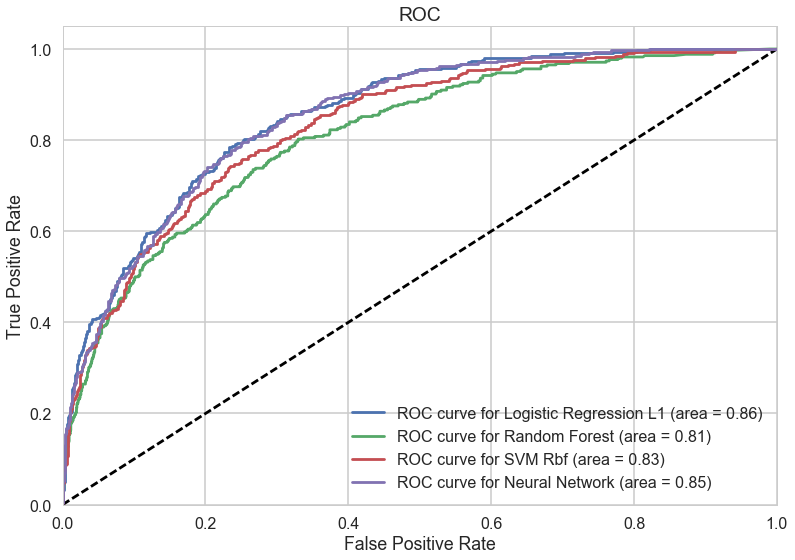

In [41]:
ax=make_roc('Logistic Regression L1',clf_l1,y_test, X_test)
# make_roc('Logistic Regression L1 PCA',clf_l1_pca,y_test, X_test_scaled_pca)
# make_roc('Logistic Regression L2',clf_l2,y_test, X_test,ax)
make_roc('Random Forest',clf_rf,y_test, X_test,ax)
# make_roc('Random Forest PCA',clf_rf_pca,y_test, X_test_scaled_pca,ax)
# make_roc('SVM Linear',clf_svc,y_test, X_test_scaled,ax,proba=False)
make_roc('SVM Rbf',clf_svm_Rbf,y_test, X_test,ax,proba=False)
# make_roc('SVM Linear PCA',clf_svc_pca,y_test, X_test_scaled_pca,ax,proba=False)
# make_roc('SVM Rbf PCA',clf_svm_Rbf_pca,y_test, X_test_scaled_pca,ax,proba=False)
# make_roc('KNN',clf_knn,y_test, X_test,ax)
# make_roc('KNN PCA',clf_knn_pca,y_test, X_test_scaled_pca,ax)
make_roc('Neural Network',clf_mlp,y_test, X_test,ax)
# make_roc('Xgboost',clf_Xgb,y_test, X_test,ax)

#### Select models by profit analysis

In [42]:
def av_profit(tpr, fpr, util, priorp, priorn):
    profit = priorp*(util[1][1]*tpr+util[1][0]*(1.-tpr))+priorn*(util[0][0]*(1.-fpr) +util[0][1]*fpr)
    return profit

In [43]:
prep_and_mail=3
profit_margin=0.3

In [44]:
tnc=0.0 #tnr stands for "true negative cost"
tpc=prep_and_mail - df.AVRG.mean()*profit_margin 
fnc = df.AVRG.mean()*profit_margin
fpc=prep_and_mail

In [45]:
risk_matrix=np.array([[tnc, fpc],[fnc, tpc]])
u = - risk_matrix
u

array([[ -0.        ,  -3.        ],
       [-34.39320686,  31.39320686]])

In [46]:
priorp=np.mean(y_test)
priorn=1. - priorp

In [47]:
def average_profit_pp(y, ypred, u):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*u)/np.sum(c)
    return score

#### baseline model

In [48]:
testsize = y_test.shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
print confusion_matrix(y_test, ypred_dste)
dsteval=average_profit_pp(y_test, ypred_dste, u)
dsteval

[[1756    0]
 [ 344    0]]


-5.6339348375508589

In [49]:
ypred_ste = np.ones(y_test.shape[0], dtype="int")
print confusion_matrix(y_test, ypred_ste)
steval = average_profit_pp(y_test, ypred_ste, u)
steval

[[   0 1756]
 [   0  344]]


2.6339348375508589

#### model comapre with baseline

In [50]:
ypred=clf_l1.predict(X_test)
print confusion_matrix(y_test, ypred)
average_profit_pp(y_test, ypred, u)

[[1721   35]
 [ 245   99]]


-2.5825753338774824

In [51]:
ypred=clf_mlp.predict(X_test)
print confusion_matrix(y_test, ypred)
average_profit_pp(y_test, ypred, u)

[[1709   47]
 [ 241  103]]


-2.4744107363264654

In [52]:
ypred=clf_svm_Rbf.predict(X_test)
print confusion_matrix(y_test, ypred)
average_profit_pp(y_test, ypred, u)

[[1756    0]
 [ 344    0]]


-5.6339348375508589

#### Change threshold for penalizing false negative

In [53]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [54]:
confusion_matrix(y_test,t_repredict(clf_l1, 0.05, X_test))

array([[796, 960],
       [ 14, 330]])

In [55]:
average_profit_pp(y_test, t_repredict(clf_l1, 0.95, X_test), u)

-5.6339348375508589

In [56]:
average_profit_pp(y_test, t_repredict(clf_l1, 0.05, X_test), u)

3.3325016032651571

#### Profit curve

In [57]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc
def av_profit(tpr, fpr, util, priorp, priorn):
    profit = priorp*(util[1][1]*tpr+util[1][0]*(1.-tpr))+priorn*(util[0][0]*(1.-fpr) +util[0][1]*fpr)
    return profit

def make_profit(name, clf, ytest, xtest, util, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_profit(tpr[i], fpr[i], util, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='utlity curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

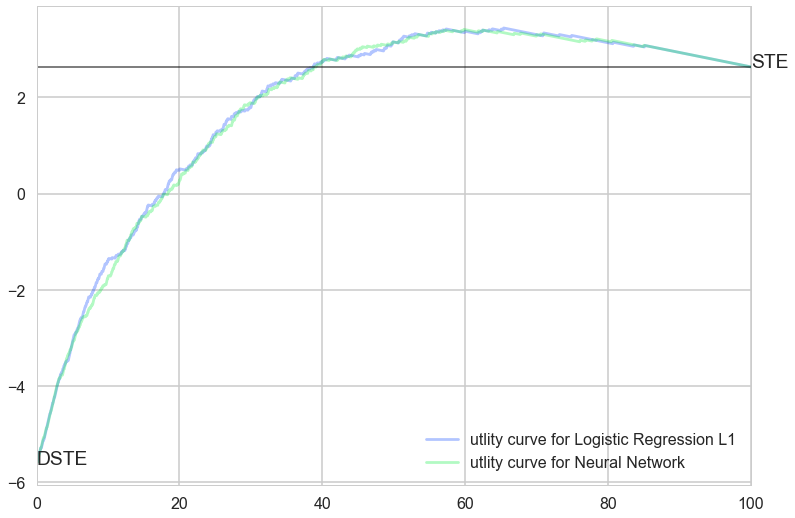

In [58]:
with sns.color_palette("bright"):
    ax=make_profit('Logistic Regression L1', clf_l1, y_test, X_test, u)
    # make_roc('Logistic Regression L1 PCA',clf_l1_pca,y_test, X_test_scaled_pca)
    # make_profit('Logistic Regression L2',clf_l2,y_test, X_test,u)
    # make_profit('Random Forest',clf_rf,y_test, X_test,u)
    # make_profit('Random Forest PCA',clf_rf_pca,y_test, X_test_scaled_pca,u)
    # make_profit('SVM Linear',clf_svc,y_test, X_test_scaled,u,proba=False)
    # make_profit('SVM Rbf',clf_svm_Rbf,y_test, X_test_scaled,u,proba=False)
    # make_profit('SVM Linear PCA',clf_svc_pca,y_test, X_test_scaled_pca,u,proba=False)
    # make_profit('SVM Rbf PCA',clf_svm_Rbf_pca,y_test, X_test_scaled_pca,u,proba=False)
    # make_roc('KNN',clf_knn,y_test, X_test,ax)
    # make_profit('KNN PCA',clf_knn_pca,y_test, X_test_scaled_pca,u)
    make_profit('Neural Network',clf_mlp,y_test, X_test,u)
    # make_profit('Xgboost',clf_Xgb,y_test, X_test,u)
    
    ax.annotate("DSTE", (0.0, dsteval))
    ax.annotate("STE", (100.0, steval))
    plt.plot([0,100],[steval,steval],'k-', alpha=0.5, lw=2)
    plt.xlim([0,100])

#### Feature selection

In [59]:
from sklearn.feature_selection import SelectKBest

In [63]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals

In [69]:
%%time
from sklearn.linear_model import LogisticRegression
logclf=LogisticRegression(penalty="l1")
k_selected=SelectKBest(k=20,score_func=pearson_scorer).fit(X_train, y_train)

Wall time: 12 ms


In [70]:
k_selected_index=k_selected.get_support()

In [78]:
X_train_fs=X_train[X_train.columns[k_selected_index]]
X_test_fs=X_test[X_train.columns[k_selected_index]]

In [83]:
%%time
from sklearn.linear_model import LogisticRegression
logclf=LogisticRegression(penalty="l1")
c={"C": [0.001, 0.1,10.0,100.0]}
clf_l1=cv_optimize(logclf,c,X_train_fs,y_train,X_test_fs,y_test)

BEST {'C': 0.1} 0.856734693878 [mean: 0.84429, std: 0.00037, params: {'C': 0.001}, mean: 0.85673, std: 0.00815, params: {'C': 0.1}, mean: 0.85633, std: 0.00454, params: {'C': 10.0}, mean: 0.85551, std: 0.00450, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.87
[[1723   33]
 [ 242  102]]
########################################################
Wall time: 1.29 s


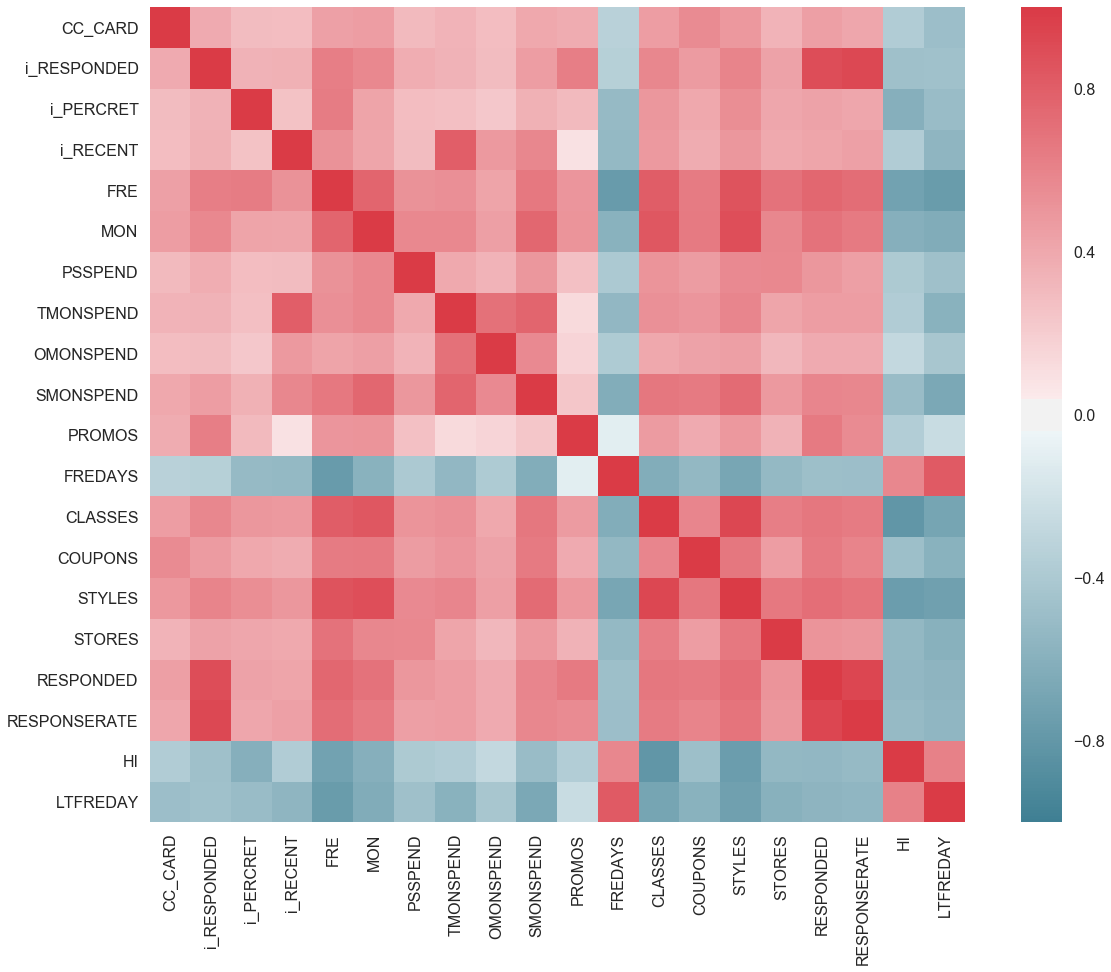

In [84]:
import seaborn as sns

f, ax = plt.subplots(figsize=(20, 15))
corr = X_train_fs.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [85]:
clf_l1.coef_

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.71739268,
         0.        , -0.08687711,  0.03080714,  0.        ,  0.00568396,
         0.        ,  0.85531951, -0.07283596, -0.01139658,  0.        ,
         0.        ,  0.        ,  0.11679948,  0.04647677, -1.70489395]])

In [86]:
def nonzero_lasso(clf,col):
    featuremask=(clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=col, 
                             coef=clf.coef_[0], 
                             abscoef=np.abs(clf.coef_[0])))[featuremask].sort('abscoef', ascending=False)

In [87]:
lasso_importances=nonzero_lasso(clf_l1,X_train_fs.columns)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.head(20)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,abscoef,coef
feature,,
LTFREDAY,1.704894,-1.704894
FREDAYS,0.855320,0.855320
FRE,0.717393,0.717393
RESPONSERATE,0.116799,0.116799
PSSPEND,0.086877,-0.086877
CLASSES,0.072836,-0.072836
HI,0.046477,0.046477
TMONSPEND,0.030807,0.030807
COUPONS,0.011397,-0.011397


In [88]:
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()
parameters = {"n_estimators": range(1, 10), "max_depth": [4, 5, 6, 7,8,9,10],'min_samples_leaf': [ 3, 4, 5, 6]}
clf_rf=cv_optimize(clfForest,parameters,X_train_fs,y_train,X_test_fs,y_test)

BEST {'n_estimators': 8, 'max_depth': 4, 'min_samples_leaf': 4} 0.858367346939 [mean: 0.84694, std: 0.01081, params: {'n_estimators': 1, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85531, std: 0.00938, params: {'n_estimators': 2, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85551, std: 0.00791, params: {'n_estimators': 3, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85163, std: 0.01026, params: {'n_estimators': 4, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85204, std: 0.00782, params: {'n_estimators': 5, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85224, std: 0.00661, params: {'n_estimators': 6, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85551, std: 0.00991, params: {'n_estimators': 7, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85388, std: 0.00567, params: {'n_estimators': 8, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.85531, std: 0.01160, params: {'n_estimators': 9, 'max_depth': 4, 'min_samples_leaf': 3}, mean: 0.84796, std: 0.00725, params: {'n_estima

In [89]:
from sklearn.svm import SVC
rbf_svm= SVC()
c_grid={'C': [0.001, 0.001,0.1, 1.0, 100.0,1000.0],'gamma':[1e-5, 1e-7,1e-8, 1e-9]}
clf_svm_Rbf=cv_optimize(rbf_svm,c_grid,X_train_fs,y_train,X_test_fs,y_test)

BEST {'C': 0.001, 'gamma': 1e-05} 0.844285714286 [mean: 0.84429, std: 0.00037, params: {'C': 0.001, 'gamma': 1e-05}, mean: 0.84429, std: 0.00037, params: {'C': 0.001, 'gamma': 1e-07}, mean: 0.84429, std: 0.00037, params: {'C': 0.001, 'gamma': 1e-08}, mean: 0.84429, std: 0.00037, params: {'C': 0.001, 'gamma': 1e-09}, mean: 0.84429, std: 0.00037, params: {'C': 0.001, 'gamma': 1e-05}, mean: 0.84429, std: 0.00037, params: {'C': 0.001, 'gamma': 1e-07}, mean: 0.84429, std: 0.00037, params: {'C': 0.001, 'gamma': 1e-08}, mean: 0.84429, std: 0.00037, params: {'C': 0.001, 'gamma': 1e-09}, mean: 0.84429, std: 0.00037, params: {'C': 0.1, 'gamma': 1e-05}, mean: 0.84429, std: 0.00037, params: {'C': 0.1, 'gamma': 1e-07}, mean: 0.84429, std: 0.00037, params: {'C': 0.1, 'gamma': 1e-08}, mean: 0.84429, std: 0.00037, params: {'C': 0.1, 'gamma': 1e-09}, mean: 0.84429, std: 0.00037, params: {'C': 1.0, 'gamma': 1e-05}, mean: 0.84429, std: 0.00037, params: {'C': 1.0, 'gamma': 1e-07}, mean: 0.84429, std: 0.00

In [90]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(random_state=0)
c_grid={'hidden_layer_sizes':[2,3,4,5,6],'activation': ['logistic', 'tanh','relu']}
clf_mlp=cv_optimize(clf_mlp,c_grid,X_train_fs,y_train,X_test_fs,y_test)

BEST {'activation': 'relu', 'hidden_layer_sizes': 6} 0.857551020408 [mean: 0.84429, std: 0.00037, params: {'activation': 'logistic', 'hidden_layer_sizes': 2}, mean: 0.85653, std: 0.00578, params: {'activation': 'logistic', 'hidden_layer_sizes': 3}, mean: 0.85531, std: 0.00477, params: {'activation': 'logistic', 'hidden_layer_sizes': 4}, mean: 0.85673, std: 0.00926, params: {'activation': 'logistic', 'hidden_layer_sizes': 5}, mean: 0.85735, std: 0.00810, params: {'activation': 'logistic', 'hidden_layer_sizes': 6}, mean: 0.85204, std: 0.00725, params: {'activation': 'tanh', 'hidden_layer_sizes': 2}, mean: 0.84959, std: 0.00976, params: {'activation': 'tanh', 'hidden_layer_sizes': 3}, mean: 0.85327, std: 0.00743, params: {'activation': 'tanh', 'hidden_layer_sizes': 4}, mean: 0.85163, std: 0.00854, params: {'activation': 'tanh', 'hidden_layer_sizes': 5}, mean: 0.85531, std: 0.00765, params: {'activation': 'tanh', 'hidden_layer_sizes': 6}, mean: 0.85204, std: 0.00640, params: {'activation':

#### ROC with selected features

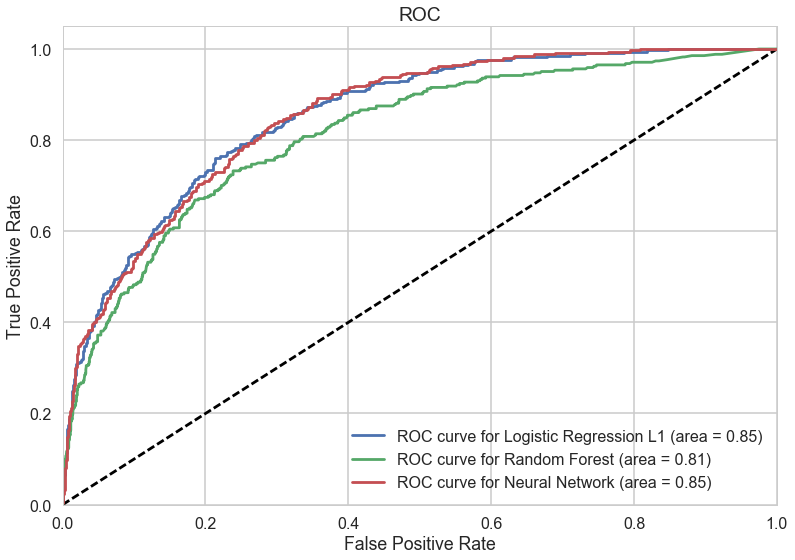

In [91]:
ax=make_roc('Logistic Regression L1',clf_l1,y_test, X_test_fs)
# make_roc('Logistic Regression L1 PCA',clf_l1_pca,y_test, X_test_scaled_pca)
# make_roc('Logistic Regression L2',clf_l2,y_test, X_test,ax)
make_roc('Random Forest',clf_rf,y_test, X_test_fs,ax)
# make_roc('Random Forest PCA',clf_rf_pca,y_test, X_test_scaled_pca,ax)
# make_roc('SVM Linear',clf_svc,y_test, X_test_scaled,ax,proba=False)
# make_roc('SVM Rbf',clf_svm_Rbf,y_test, X_test_fs,ax,proba=False)
# make_roc('SVM Linear PCA',clf_svc_pca,y_test, X_test_scaled_pca,ax,proba=False)
# make_roc('SVM Rbf PCA',clf_svm_Rbf_pca,y_test, X_test_scaled_pca,ax,proba=False)
# make_roc('KNN',clf_knn,y_test, X_test,ax)
# make_roc('KNN PCA',clf_knn_pca,y_test, X_test_scaled_pca,ax)
make_roc('Neural Network',clf_mlp,y_test, X_test_fs,ax)
# make_roc('Xgboost',clf_Xgb,y_test, X_test,ax)

### Balance Data

In [190]:
df_train['RESP'].value_counts()

0    4137
1     763
Name: RESP, dtype: int64

In [131]:
X_train.shape

(4900, 68)

In [191]:
# jtrain_new=np.arange(0, X_train.shape[0])
ipos_new = np.random.choice(X_train[y_train==1].index, 700, replace=False)
ineg_new = np.random.choice(X_train[y_train==0].index, 700, replace=False)
subsampled_i=np.concatenate((ipos_new,ineg_new))
X_train_blc=X_train.ix[subsampled_i]
y_train_blc=y_train.ix[subsampled_i]

In [192]:
X_train_blc.shape,y_train_blc.shape

((1400, 68), (1400L,))

In [193]:
from sklearn.svm import LinearSVC

clfsvm=LinearSVC(loss="hinge")
c_grid={'C':[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
clf_svc=cv_optimize(clfsvm,c_grid,X_train_blc,y_train_blc,X_test,y_test,score_func='f1')

BEST {'C': 0.1} 0.752713668283 [mean: 0.71363, std: 0.02351, params: {'C': 0.001}, mean: 0.74155, std: 0.01968, params: {'C': 0.01}, mean: 0.75271, std: 0.02058, params: {'C': 0.1}, mean: 0.75004, std: 0.02022, params: {'C': 1.0}, mean: 0.74779, std: 0.02476, params: {'C': 10.0}, mean: 0.59225, std: 0.10783, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.75
Accuracy on test data:     0.73
[[1247  509]
 [  63  281]]
########################################################


In [201]:
%%time
from sklearn.linear_model import LogisticRegression
logclf=LogisticRegression(penalty="l1")
c={"C": [0.001, 0.1,10.0,100.0]}
clf_l1_blc=cv_optimize(logclf,c,X_train_blc,y_train_blc,X_test,y_test)

BEST {'C': 10.0} 0.741428571429 [mean: 0.50000, std: 0.00000, params: {'C': 0.001}, mean: 0.73786, std: 0.02365, params: {'C': 0.1}, mean: 0.74143, std: 0.02343, params: {'C': 10.0}, mean: 0.74071, std: 0.01938, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.77
Accuracy on test data:     0.75
[[1314  442]
 [  78  266]]
########################################################
Wall time: 1.72 s


In [217]:
%%time
from sklearn.linear_model import LogisticRegression
logclf=LogisticRegression(penalty="l1")
c={"C": [0.001, 0.1,10.0,100.0]}
clf_l1=cv_optimize(logclf,c,X_train,y_train,X_test,y_test)

BEST {'C': 0.1} 0.855510204082 [mean: 0.84429, std: 0.00037, params: {'C': 0.001}, mean: 0.85551, std: 0.00485, params: {'C': 0.1}, mean: 0.85347, std: 0.00499, params: {'C': 10.0}, mean: 0.85327, std: 0.00613, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.87
[[1721   35]
 [ 245   99]]
########################################################
Wall time: 10.6 s


#### Feature selected and balanced

In [207]:
X_train_fs_blac=X_train_blc[X_train_blc.columns[k_selected_index]]
X_test_fs=X_test[X_train_blc.columns[k_selected_index]]

In [223]:
%%time
from sklearn.linear_model import LogisticRegression
logclf=LogisticRegression(penalty="l1")
c={"C": [0.001, 0.1,10.0,100.0]}
clf_l1_blc_fs=cv_optimize(logclf,c,X_train_fs_blac,y_train_blc,X_test_fs,y_test)

BEST {'C': 0.1} 0.739285714286 [mean: 0.50000, std: 0.00000, params: {'C': 0.001}, mean: 0.73929, std: 0.03218, params: {'C': 0.1}, mean: 0.73714, std: 0.02924, params: {'C': 10.0}, mean: 0.73643, std: 0.03076, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.74
Accuracy on test data:     0.76
[[1319  437]
 [  75  269]]
########################################################
Wall time: 386 ms


In [215]:
from sklearn.svm import LinearSVC

clfsvm=LinearSVC(loss="hinge")
c_grid={'C':[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
clf_svc=cv_optimize(clfsvm,c_grid,X_train_fs_blac,y_train_blc,X_test_fs,y_test,score_func='f1')

BEST {'C': 1.0} 0.753471114063 [mean: 0.72404, std: 0.03008, params: {'C': 0.001}, mean: 0.73570, std: 0.02815, params: {'C': 0.01}, mean: 0.74819, std: 0.03247, params: {'C': 0.1}, mean: 0.75347, std: 0.02511, params: {'C': 1.0}, mean: 0.75072, std: 0.02745, params: {'C': 10.0}, mean: 0.74318, std: 0.04549, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.74
Accuracy on test data:     0.74
[[1281  475]
 [  67  277]]
########################################################


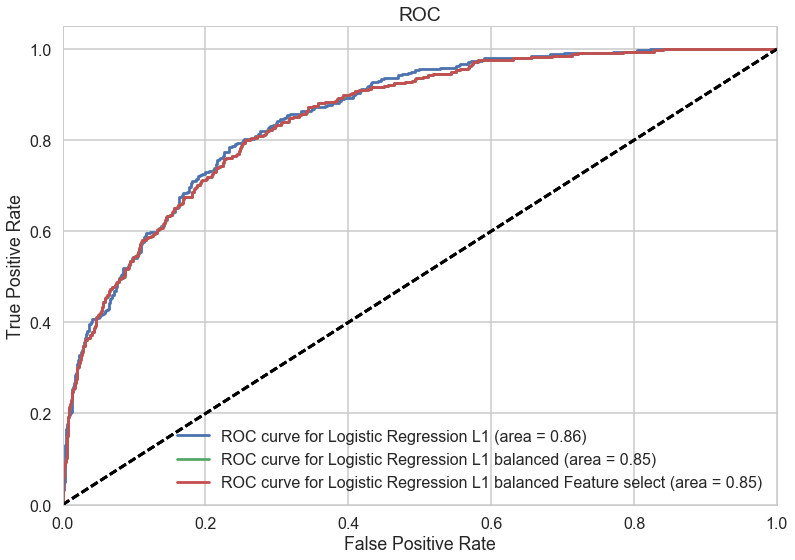

In [224]:
ax=make_roc('Logistic Regression L1',clf_l1,y_test, X_test)
make_roc('Logistic Regression L1 balanced',clf_l1_blc,y_test, X_test_fs)
make_roc('Logistic Regression L1 balanced Feature select',clf_l1_blc_fs,y_test, X_test_fs)
# make_roc('Logistic Regression L1 PCA',clf_l1_pca,y_test, X_test_scaled_pca)
# make_roc('Logistic Regression L2',clf_l2,y_test, X_test,ax)
# make_roc('Random Forest',clf_rf,y_test, X_test_fs,ax)
# make_roc('Random Forest PCA',clf_rf_pca,y_test, X_test_scaled_pca,ax)
# make_roc('SVM Linear',clf_svc,y_test, X_test_scaled,ax,proba=False)
# make_roc('SVM Rbf',clf_svm_Rbf,y_test, X_test_fs,ax,proba=False)
# make_roc('SVM Linear PCA',clf_svc_pca,y_test, X_test_scaled_pca,ax,proba=False)
# make_roc('SVM Rbf PCA',clf_svm_Rbf_pca,y_test, X_test_scaled_pca,ax,proba=False)
# make_roc('KNN',clf_knn,y_test, X_test,ax)
# make_roc('KNN PCA',clf_knn_pca,y_test, X_test_scaled_pca,ax)
# make_roc('Neural Network',clf_mlp,y_test, X_test_fs,ax)
# make_roc('Xgboost',clf_Xgb,y_test, X_test,ax)

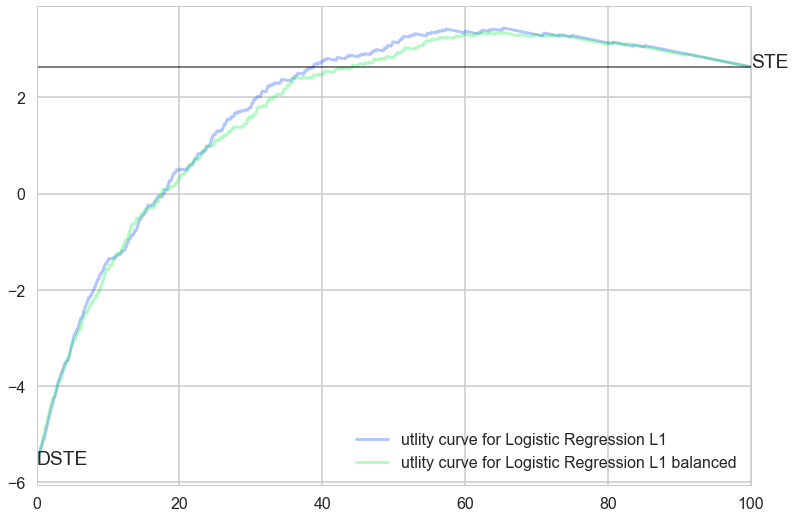

In [206]:
with sns.color_palette("bright"):
    ax=make_profit('Logistic Regression L1', clf_l1, y_test, X_test, u)
    make_profit('Logistic Regression L1 balanced', clf_l1_blc, y_test, X_test, u)
    # make_roc('Logistic Regression L1 PCA',clf_l1_pca,y_test, X_test_scaled_pca)
    # make_profit('Logistic Regression L2',clf_l2,y_test, X_test,u)
    # make_profit('Random Forest',clf_rf,y_test, X_test,u)
    # make_profit('Random Forest PCA',clf_rf_pca,y_test, X_test_scaled_pca,u)
    # make_profit('SVM Linear',clf_svc,y_test, X_test_scaled,u,proba=False)
    # make_profit('SVM Rbf',clf_svm_Rbf,y_test, X_test_scaled,u,proba=False)
    # make_profit('SVM Linear PCA',clf_svc_pca,y_test, X_test_scaled_pca,u,proba=False)
    # make_profit('SVM Rbf PCA',clf_svm_Rbf_pca,y_test, X_test_scaled_pca,u,proba=False)
    # make_roc('KNN',clf_knn,y_test, X_test,ax)
    # make_profit('KNN PCA',clf_knn_pca,y_test, X_test_scaled_pca,u)
#     make_profit('Neural Network',clf_mlp,y_test, X_test,u)
    # make_profit('Xgboost',clf_Xgb,y_test, X_test,u)
    
    ax.annotate("DSTE", (0.0, dsteval))
    ax.annotate("STE", (100.0, steval))
    plt.plot([0,100],[steval,steval],'k-', alpha=0.5, lw=2)
    plt.xlim([0,100])

### PCA

In [256]:
pca_cols1=[
 'FRE',
 'MON',
 'DAYS',
 'FREDAYS',
 'CLASSES',
 'STYLES',
 'STORES',
 'HI',
 'LTFREDAY',
 'PERCRET']

# pca_cols2=['PROMOS','COUPONS' ,'MARKDOWN']

In [263]:
from sklearn.decomposition import PCA
pca_train_eigvct = PCA(n_components=1)
pca_1 = pca_train_eigvct.fit(X_train[pca_cols1])

In [279]:
pca_1_v1_train=pca_1.transform(X_train[pca_cols1])
pca_1_v1_test=pca_1.transform(X_test[pca_cols1])

In [264]:
pca_1.components_

array([[ 0.37496334,  0.3384541 ,  0.12422836, -0.31438138,  0.36747277,
         0.37809732,  0.29926043, -0.3353352 , -0.3325521 ,  0.19997938]])

In [265]:
print(pca_1.explained_variance_ratio_)

[ 0.62563978]


In [267]:
pca_train_eigvct.explained_variance_ratio_.shape[0]

1L

In [268]:
df_train_pca = pd.DataFrame({"y":y_train.values})
for i in range(pca_train_eigvct.explained_variance_ratio_.shape[0]):
    df_train_pca["pc%i" % (i+1)] = X_train_pca[:,i]
df_train_pca.head()

,y,pc1
0,1,5.145888
1,0,-2.968581
2,0,0.543250
3,0,3.151088
4,0,1.305756


In [280]:
X_train_pca=X_train.copy()
X_test_pca=X_test.copy()

In [281]:
X_train_pca.shape

(4900, 68)

In [282]:
X_train_pca=X_train_pca.drop(pca_cols1,axis=1)
X_test_pca=X_test_pca.drop(pca_cols1,axis=1)

In [283]:
X_train_pca.shape

(4900, 58)

In [284]:
X_train_pca['purchasing habits']=pca_1_v1_train
X_test_pca['purchasing habits']=pca_1_v1_test

In [285]:
X_train_pca.shape

(4900, 59)

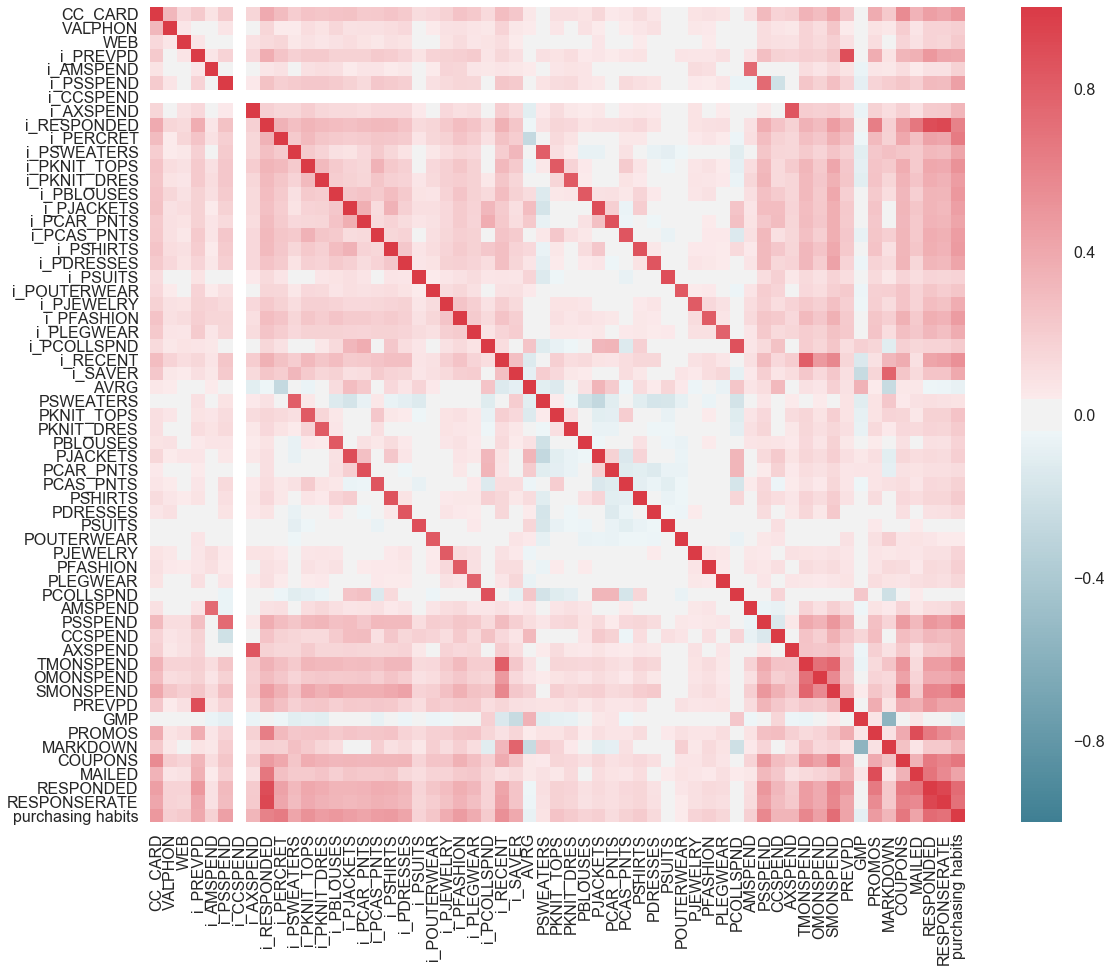

In [288]:
import seaborn as sns

f, ax = plt.subplots(figsize=(20, 15))
corr = X_train_pca.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [287]:
%%time
from sklearn.linear_model import LogisticRegression
logclf=LogisticRegression(penalty="l1")
c={"C": [0.001, 0.1,10.0,100.0]}
clf_l1_pca_fs=cv_optimize(logclf,c,X_train_pca,y_train,X_test_pca,y_test)

BEST {'C': 100.0} 0.852653061224 [mean: 0.85041, std: 0.00675, params: {'C': 0.001}, mean: 0.85102, std: 0.00990, params: {'C': 0.1}, mean: 0.85224, std: 0.00820, params: {'C': 10.0}, mean: 0.85265, std: 0.00840, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.85
[[1720   36]
 [ 276   68]]
########################################################
Wall time: 4.29 s
